# **Baixando o dataset**

In [ ]:
# Necessita da API Token para fazer download dos datasets por linha de comando
!pip install -q kaggle

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Fazer upload da API Token
from google.colab import files
files.upload()

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download do dataset fruit recognition
! kaggle datasets download chrisfilo/fruit-recognition

100% 7.91G/7.92G [03:03<00:00, 30.2MB/s]
100% 7.92G/7.92G [03:03<00:00, 46.3MB/s]


In [ ]:
# Descompacta o dataset
!unzip /content/fruit-recognition.zip -d ./fruits/

# **Criando Modelo**

### Criando o modelo escolhido na etapa de modelagem

In [5]:
import tensorflow as tf

In [6]:
# Modelo escolhido no final da fase de modelagem para ser avaliado
def modelo(im_height, im_width):
    model = tf.keras.models.Sequential(name="modelo_1")

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=(im_height, im_width, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(15, activation='softmax'))
    print(model.summary())
    return model

In [7]:
# cria e compila o modelo
model = modelo(224,224)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

Model: "modelo_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        369

# **Treinamento**

In [8]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Ler o .csv que contém o path da imagem e a classe que ela pertence
train_data = pd.read_csv('imagens_treino_avaliacao.csv')

In [10]:
# Utiliza tecnicas de data augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255, rotation_range=70)

In [11]:
image_data_generator = train_datagen.flow_from_dataframe(train_data, batch_size=64,
                                                    x_col = "filename", y_col = "label", 
                                                    class_mode = "sparse", shuffle = True, target_size=(224, 224))

Found 26752 validated image filenames belonging to 15 classes.


In [12]:
# Executa o treinamento do modelo com 6 époocas
model.fit(image_data_generator, epochs=6)

Epoch 1/6
418/418 [==============================] - 410s 965ms/step - loss: 2.1245 - accuracy: 0.2752
Epoch 2/6
418/418 [==============================] - 375s 897ms/step - loss: 0.7969 - accuracy: 0.7086
Epoch 3/6
418/418 [==============================] - 367s 878ms/step - loss: 0.5533 - accuracy: 0.8024
Epoch 4/6
418/418 [==============================] - 367s 877ms/step - loss: 0.3879 - accuracy: 0.8585
Epoch 5/6
418/418 [==============================] - 367s 878ms/step - loss: 0.3518 - accuracy: 0.8757
Epoch 6/6
418/418 [==============================] - 369s 883ms/step - loss: 0.2850 - accuracy: 0.8978


# **Avaliação**

In [13]:
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef

In [14]:
# Ler o .csv de teste
test_data = pd.read_csv('imagens_teste_avaliacao.csv')

test_datagen = ImageDataGenerator(rescale=1./255)
teste_data_generator = test_datagen.flow_from_dataframe(test_data, batch_size=64,
                                                    x_col = "filename", y_col = "label", 
                                                    class_mode = "sparse", shuffle = False, target_size=(224, 224))

# guarda o valor real de cada imagem para utilizar na matriz de confusão
y_real = teste_data_generator.classes

Found 6210 validated image filenames belonging to 15 classes.


In [15]:
y_predicted = []
# Faz a classificação dos dados de teste
pred = model.predict(teste_data_generator)

# Salva o valor predito para cada imagem classificada para utilizar na matriz de confusão
for p in pred:
    y_predicted.append(p.argmax())

### **Matriz de Confusão e Métricas**

In [16]:
classes = {
    0:"Maçã",1:"Banana",2:"Carambola",3:"Goiaba",4:"Kiwi",
    5:"Manga",6:"Laranja",7:"Pecego",8:"Pera",9:"Caqui",
    10:"Pitaia",11:"Ameixa",12:"Romã",13:"Tomate",14:"Melão"
}

#Matriz de confusão
y_true = [ classes[r] for r in y_real]
y_pred = [ classes[p] for p in y_predicted]

matriz_confusao = metrics.confusion_matrix(y_true, y_pred).transpose()

# Printa a matriz de confusão
print(matriz_confusao)

# Printa as métricas: precissão, recall e f1-score
print(metrics.classification_report(y_true, y_pred, digits=3))

# Printa a métrica MCC
print("MCC: ", matthews_corrcoef(y_true, y_pred))

[[414   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 394   0   0  27   3   0  30   0   2   0  10   0   7   0]
 [  0   0 411   0   0   0   3   0   0   0   0   0   0   0   0]
 [  0   0   0 414   9   0   0   0   0   1   0   0   0   0   0]
 [  0   4   0   0 374   7   0   6  12  20   0   6   0   1   0]
 [  0   1   0   0   0 390   0   5   1   0   6   1   0   1   0]
 [  0   0   1   0   0   0 409   2   0   0   0   0   0   0   0]
 [  0   8   0   0   0   3   1 365   0   0   0   6   0   1   0]
 [  0   1   0   0   1   1   0   2 369  29   5   5   0   1  10]
 [  0   0   0   0   0   2   0   2  20 356   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   6   1 403   0   0   1   0]
 [  0   0   0   0   3   2   0   0   5   5   0 382   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 414   0   0]
 [  0   6   2   0   0   6   1   2   0   0   0   0   0 402   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0 404]]
              precision    recall  f1-score   support


## **Heatmap**

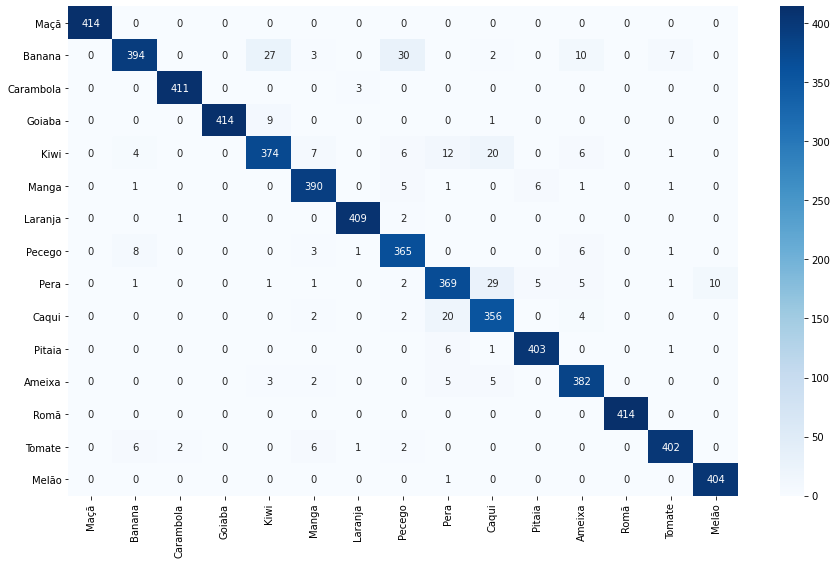

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

lbls_classes = ["Maçã","Banana","Carambola","Goiaba","Kiwi",
    "Manga","Laranja","Pecego","Pera","Caqui",
    "Pitaia","Ameixa","Romã","Tomate","Melão"]

df_mc = pd.DataFrame(matriz_confusao, index = [i for i in lbls_classes],
                  columns = [i for i in lbls_classes])
plt.figure(figsize = (15,9))
sn.heatmap(df_mc, annot=True, cmap='Blues', fmt='g')

# **Salvando o modelo com tensorflowjs**

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(m1, "./my_modeljs1")